# Calibration Examples
The computations in this notebook illustrate how one can perform a calibration between an observed sensor output and a known physical parameter. In this analysis, the variable "x" represents the sensor output, and the variable "y" represents the value of the parameter in known phsyical units. 

The examples are written in the context of a calibration between the sensor output 1/R and the physical parameter electrical conductivity. The notebook assumes that data describing the relationship betwen 1/R and EC are available at a range of different EC values.

The notebook is organized into three sections. First, computations are performed to find the instrument's cell constant k, where EC = k/R. This can be computed from each data point in a straightforward way, and confidence limits on the cell constant can be developed using a simple t-test.  Next, regression is used to develop a relationship between EC and 1/R.  In this method, k represents the slope of the regression line.  Finally, analysis is performed on the logarithms of EC and 1/R, ultimately producing a power-function that describes the relationship between EC and 1/R.

### Import Libraries
All examples require the following libraries

In [7]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats
from scipy.stats import t

### Read the example dataset
Here, we read data from an excel spreadsheet. The relevant columsn for calibration are the column 1/R, which we expect will be realted to electrical conductivity, which is described in column Kt.

In [8]:
xls = pd.ExcelFile("Calibration_data.xlsx")
sn = xls.sheet_names
data = pd.read_excel(xls,sheet_name = sn[0], header = 0)
display(data)

,T (°C),Kt,R1,R2,R,1/R,1/R (uS)
0,16.81,45404.9,2.94,19.75,11.345,0.088145,88144.557074
1,16.83,45404.9,3.79,21.83,12.810,0.078064,78064.012490
2,16.85,45404.9,2.68,21.44,12.060,0.082919,82918.739635
3,17.26,25864.4,11.73,29.18,20.455,0.048888,48887.802493
4,17.34,25864.4,11.74,31.41,21.575,0.046350,46349.942063
5,17.35,25864.4,12.48,31.09,21.785,0.045903,45903.144365
6,18.55,16073.2,37.85,36.52,37.185,0.026893,26892.564206
7,18.58,16073.2,35.33,38.86,37.095,0.026958,26957.811026
8,18.62,16073.2,34.31,39.43,36.870,0.027122,27122.321671
9,18.39,10313.4,51.54,64.95,58.245,0.017169,17168.855696


### Create separate dataframes for x and y
To make the code more adaptable for other situations, we now read the known physical property into a variable we call "x" and the sensor output into a variable we call "y".

In [9]:
y = data['1/R (uS)']  #These are instrument readings
x = data['Kt']       #These are known values (e.g., concentrations)

## Example 1:  Simple Means
For electrical conductivity, the most frequently-used model for relating the sensor output to the physical parameter is using the simple ratio k = EC/R. This model is sufficiently simple that we can simply evaluate k for each of our datapoints, then add confidence limits to this estimate.

### Compute an array of k estimates and print key statistics
Here, we use the Pandas ability to do row-by-row computations quickly. We then print out the results using Pandas built-in .mean(), .std(), and .ser() functions, which represent the mean, standard deviation, and standard error of the data, respectively.

In [10]:
k_cell = x/y
print(f'Simple mean of cell constant for all observations = {k_cell.mean():.4f}')
print(f'Standard deviation of cell constant for all observations = {k_cell.std():.4f}')
print(f'Standard error of cell constant for all observations = {k_cell.sem():.4f}')

Simple mean of cell constant for all observations = 0.5822
Standard deviation of cell constant for all observations = 0.0289
Standard error of cell constant for all observations = 0.0046


### Analyze the error
Once we have a model, we are interested in computing the precision of the model.  Here, we can do this by first computing the difference between the observed physical parameter and the estimate we get from our model.  

In [11]:
mean_k_cell = k_cell.mean()
predicted = y*mean_k_cell
observed = x
error = predicted - observed
print(f'Standard deviation of error = {error.std():.1f}')

Standard deviation of error = 1149.2


### Compute 95% confidence limits on the error
This is traditionally done using the well-known student's t-distribution (a typical topic for an introductory statistics course). The confidence limits on the error, $CL_E$, represent the range within which we expect the error $E$ to fall a specified fraction $\alpha$ of the time.

$CL_E = \overline{E} \pm t_{({1-\alpha/2,n-1})}s_E$

The $t$ statistic is accessible using the scipy.stats library, which we've already imported. The computation of confidence limits requires the specification of the confidence interval $\alpha$ (we use 95% here), the number of degrees of freedom, which is normally the number of data points $n$ minus the number of parameters being estimated (1 in this case), a mean error $\overline{E}$ (which we assume is zero, since error could be positive and negative), and the standard deviation of error computed from the sample, $s_E$. 

In [12]:
n = len(error)
[error_lower, error_upper] = t.interval(alpha=0.95,
                                          df=n-1,
                                          loc=0,
                                          scale=error.std()
                                       )
print(f'Confidence Limits on Error = \u00B1 {(error_upper - error_lower)/2:.1f}')

Confidence Limits on Error = ± 2326.4


You might be bothered by the fact that this much error is a relatively large fraction of the measurement if we are at the low end of the instrument's range.  A better approach could be to analyze the relative error, that is, the error at each data point divided by the measurement at that point. 

In [33]:
relative_error = (predicted - observed)/observed
[relative_lower, relative_upper] = t.interval(alpha = 0.95,
                                             df = n-1,
                                             loc = 0,
                                             scale = relative_error.std()
                                             )
print(f'Confidence Limits on Relative Error = \u00B1 {(relative_upper - relative_lower)/2:.3f}')
print(f'Confidence Limits on Percent Error = \u00B1 {100*(relative_upper - relative_lower)/2:.1f} %')

Confidence Limits on Relative Error = ± 0.101
Confidence Limits on Percent Error = ± 10.1 %


These results give us a broad-brush estimate of the precision of the device.

### Compute 95% confidence limits on the mean
It is sometimes also useful to compute the confidence we have in one of our model parameters.  In this case, we can use a t-test to put confidence limits on the mean cell constant. The only difference here is that the standard deviation for a mean computed from $n$ measurements, also known as the standard error, is not simply the standard deviation of the measurements--it's actually that standard deviation of the measurements in the sample, $s$, divided by the square root of the number of measurements $n$.

standard error = $\frac{s}{\sqrt{n}}$

We can now use our equation for confidence limits to place an interval around the mean cell constant, this time using the the standard error as the sample standard deviation and using the mean cell constant as the mean value. As above, we can also present this as a fraction and/or a percentage of the mean cell constant.

In [14]:
[k_cell_lower, k_cell_upper] = t.interval(alpha=0.95,
                                          df=len(k_cell)-1,
                                          loc=k_cell.mean(),
                                          scale=k_cell.sem()
                                          ) 
delta_k_cell = (k_cell_upper-k_cell_lower)/2
percent_error = delta_k_cell / k_cell.mean() * 100
print(f'Cell constant k = {k_cell.mean():.4f} \u00B1 {delta_k_cell:.4f}')
print(f'This implies relative error in estimate of k of = {delta_k_cell:.4f} / {k_cell.mean():.4f} = {percent_error:.2f}%')

Cell constant k = 0.5822 ± 0.0094
This implies relative error in estimate of k of = 0.0094 / 0.5822 = 1.61%


Note that the confidence limits on our estimate for the parameter k are MUCH narrower (i.e., is much greater) than the confidence we might have in any single measurement made by the device.

## Example 2: Linear Regression
One of the major drawbacks at stopping with example 1 is that we have not visualized the data and thus are unsure whether there were any patterns in goodness of fit that depend on EC (or even whether the data really appear linear).

### Visualize Raw Data
We can start our graphical analyis by plotting our data.

Text(0, 0.5, '1/R')

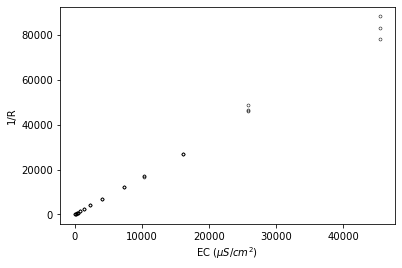

In [15]:
fig, ax = plt.subplots(1,1)
plt.rc('xtick',labelsize=8)
plt.rc('ytick',labelsize=8)
ax.plot(x,y,
         color = 'black', 
         markeredgewidth=0.5,
         marker = 'o',
         linestyle = 'none',
         markersize = '3',
         fillstyle='none',
         label = 'Observed data',
         )
ax.set_xlabel('EC ($\mu S/cm^2$)')
ax.set_ylabel('1/R') 

In the above dataset, data were collected in triplicate (so three points per EC value), starting at a high EC value.  The solution was the diluted by approximately a factor of two for each subsequent EC value.

### Perform regression and present some goodness of fit statistics
The scipy.stats library includes methods for doing a least-squares linear regression. The function exports the slope and y-intercept of the equation as well as the correlation coefficient $R$, the p-value, and the standard error.

In [16]:
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print(f'Linear regression gives y = {slope:.4f}x + {intercept:.4f}')
print(f'This implies cell constant = 1/{slope:.4f} = {1/slope:.4f}')

Linear regression gives y = 1.8214x + -455.5096
This implies cell constant = 1/1.8214 = 0.5490


### Define function for computing  confidence interval on estimated parameter.

The approach presented here is described in detail in Lavagnini and Magno, 2007, Mass Spectrometry Reviews 26, 1-18.

The function uses the observed data points x and y, along with the linear y-intercept b0, slope b1, number of replicates expected in a future measurement m (often m = 1), to present the upper and lower lower confidence limits for any value of the physical parameter xtilde_0. Alpha represents the probability that a measurement will fall within the confidence interval between xplus and xminus.

In [17]:
def prediction_limits(x,y,b0,b1,m,xtilde_0,alpha):
    n = x.size
    ytilde = b0 + b1*x
    xbar = x.mean()
    s2_yx = ((y-ytilde)**2).sum()/(n-2)
    s2_xtilde_0 = (s2_yx/b1**2)*(1/m+1/n+((xtilde_0-xbar)**2)/((x-xbar)**2).sum())
    s_xtilde_0 = s2_xtilde_0**0.5
    t_stat = t.ppf(1-alpha/2,df=n-2)   
    xplus = xtilde_0 + t_stat*s_xtilde_0
    xminus = xtilde_0 - t_stat*s_xtilde_0
    
    return(xminus,xtilde_0,xplus)

With the function defined, we are now able to apply it to any input values of the known physical parameter we like.  Here, we create a wide range of posible input values using numpy's np.linspace command, evaluate the upper and lower limits using our function. Finally we compute the sensor output that would correspond with each one of our input EC values (our xhat).

In [18]:
xhat = np.linspace(20,50000,5)
[xminus, xhat0, xplus] = prediction_limits(x,y,intercept,slope,1,xhat,.05)
yhat = intercept +slope*xhat

### Graph results 
Now that we have our best-fit line (xhat vs. yhat) and the confidence limits (xminus vs. yhat) and (xplus vs. yhat), we can add these to our graph. Here, we also format text to describe the calibration equation that is included in the graph. Note that the inverse of this equation is what is normally used to compute a physical value from a sensor reading.

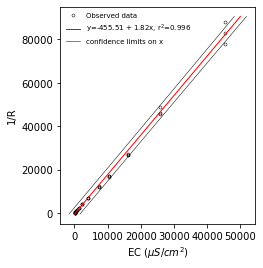

In [19]:
linear_fit = ax.plot(xhat, yhat,
    color = 'red',
    linewidth = 1,
    label = f'y={intercept:4.2f} + {slope:4.2f}x, r$^2$={r_value**2:4.3f}'
    )

upper_limit = ax.plot(xplus, yhat,
    color = 'black',
    linewidth = 0.5,
    label = 'confidence limits on x'
    )

lower_limit = ax.plot(xminus, yhat,
    color = 'black',
    linewidth = 0.5,
    )

ax.legend(frameon=False, loc='upper left', prop={'size':7})#, ncol=3)
fig.set_size_inches(3.5,4)
fig

## Example 3: Log-Log Regression
The data used in the linear regression presented in Example 2 appears clustered near the lower EC range. This effect occurs because we varied EC in the experiments by dilluting by a factor of two. The non-even nature of the range between points means that linear regression is not the best approach for fitting a line to the data. Furthermore, the errors at the high end of the EC range are evidently much greater than the error at the low end.  We can handle this y repeating all of the above analysis, but instead of performing the analysis on the raw values, we perform the analysis on the natural logs of the values.

### Transform raw data to log scale

In [20]:
x = np.log(x)
y = np.log(y)

### Graph the natural logs

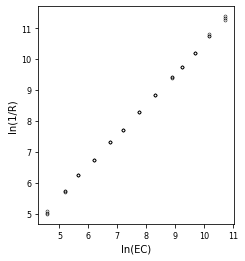

In [21]:
fig2, ax2 = plt.subplots(1,1)
plt.rc('xtick',labelsize=8)
plt.rc('ytick',labelsize=8)
dataseries = ax2.plot(x,y,
         color = 'black', 
         markeredgewidth=0.5,
         marker = 'o',
         linestyle = 'none',
         markersize = '3',
         fillstyle='none',
         label = 'Observed data', 
         )
ax2.set_xlabel('ln(EC)')
ax2.set_ylabel('ln(1/R)')
fig2.set_size_inches(3.5,4)

Note now that the data appear to have a much more even spacing.  This is because we cut the concentration by a constant fraction with each dilution. now, because the data are spaced evenly, a regression is more appropriate.

### Perform the regression and print results

In [22]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print(f'Linear regression gives ln(y) = {slope:.4f}ln(x) + {intercept:.4f}')


Linear regression gives ln(y) = 1.0060ln(x) + 0.4958


### Find the prediction interval for the natural logs for a wide range of potential physical values

We can now use the same function as before to estimate the prediction interval within with 95% of datapoints are expected to fall. Now, the output of the function simply gives us the range within which 95% of the natural logs would be expected. In order to make the graph, we now need to provide as input natural logs, not raw numbers.

In [23]:
xhat = np.linspace(np.log(50),np.log(50000),1000)
[xminus, xhat0, xplus] = prediction_limits(x,y,intercept,slope,1,xhat,.05)
yhat = intercept +slope*xhat

### Graph the results in log space
We can now produce graphs just like before, but with the x- and y-scales presenting the natural logs of the physical parameter and the sensor value.

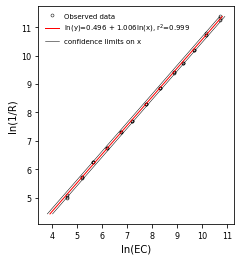

In [24]:
linear_fit = ax2.plot(xhat, yhat,
    color = 'red',
    linewidth = 1,
    label = f'ln(y)={intercept:4.3f} + {slope:4.3f}ln(x), r$^2$={r_value**2:4.3f}'
    )

upper_limit = ax2.plot(xplus, yhat,
    color = 'black',
    linewidth = 0.5,
    label = 'confidence limits on x'
    )

lower_limit = ax2.plot(xminus, yhat,
    color = 'black',
    linewidth = 0.5,
    )
ax2.legend(frameon=False, loc='upper left', prop={'size':7})#, ncol=3)
fig2.set_size_inches(3.5,4)
fig2


Now, it's clear that most of our data points fall within the prediction interval, regardless of the raw EC value.

### Re-transform to real-world units
We now have a large number of data points that all represent the natural logarithms of the data we actually care about.  We can now re-transform these to regular units by taking the anti-log of each value. For natural logarithms, this is by use of the exponential function (from the numpy library). We do this for all values, including the prediction limits.

In [25]:
x = np.exp(x)
y = np.exp(y)
xhat = np.exp(xhat)
yhat = np.exp(yhat)
xplus = np.exp(xplus)
xminus = np.exp(xminus)

### Graph the results of the log-log regression in real units
The only thing left to do is to graph our results. The parameters of the line on the log-log regression also allow us to present the results as a power function.

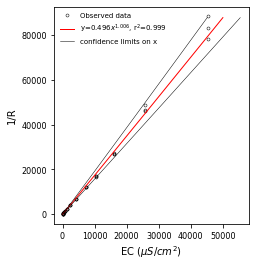

In [26]:
fig3, ax3 = plt.subplots(1,1)
plt.rc('xtick',labelsize=8)
plt.rc('ytick',labelsize=8)
dataseries = ax3.plot(x,y,
         color = 'black', 
         markeredgewidth=0.5,
         marker = 'o',
         linestyle = 'none',
         markersize = '3',
         fillstyle='none',
         label = 'Observed data', 
         )
ax3.set_xlabel('EC ($\mu S/cm^2$)')
ax3.set_ylabel('1/R')        

linear_fit = ax3.plot(xhat, yhat,
    color = 'red',
    linewidth = 1,
    label = ('y=%4.3f$x^{%4.3f}$, r$^2$=%4.3f' % (intercept, slope, r_value**2))
    )

upper_limit = ax3.plot(xplus, yhat,
    color = 'black',
    linewidth = 0.5,
    label = 'confidence limits on x'
    )

lower_limit = ax3.plot(xminus, yhat,
    color = 'black',
    linewidth = 0.5,
    )

ax3.legend(frameon=False, loc='upper left', prop={'size':7})#, ncol=3)
fig3.set_size_inches(3.5,4)

Now, the prediction interval expands with the range of the variability of the raw datapoints in a plausible way.

### Interpretation and use with a specific sensor reading

The functional relationships graphed in the figure allow a measurement made by the sensor to be converted both to a best-estimate of the physical parameter in question (EC here, as represented by the red line) as well as the best estimates of the 95% confidence limits for a measurement.  For example, a given reading on the y-axis, say 1/R = 20,000, can be converted to a best estimate on the x-axis using the parameters of the regression and the prediction limits function. Here, we use the results of the log-log regression, and the result is printed to the screen.

In [27]:
sensor_reading = 20000  #this represents 1/R
ln_sensor_reading = np.log(sensor_reading)  #this is the log of the sensor reading--represents y in regression
ln_physical_parameter = (ln_sensor_reading - intercept) / slope  #solved as inverse of linear equation
ln_x = np.log(x)
ln_y = np.log(y)
ln_results = prediction_limits(ln_x,ln_y,intercept,slope,1,ln_physical_parameter,.05)
[lower,best,upper] = np.exp(ln_results)
print(f'For the case where a sensor 1/R is {sensor_reading}, the corresponding range for the physical parameter is:')
print(f'Lower Limit = {lower:.0f}, Best Estimate = {best:.0f}, Upper Limit = {upper:.0f}')

For the case where a sensor 1/R is 20000, the corresponding range for the physical parameter is:
Lower Limit = 10414, Best Estimate = 11515, Upper Limit = 12734


Note that the because of the log-transformation (or more precisely--the anti-log), the difference between best estimate and the lower and upper limits is no longer precisely constant. Also note that the range between the two prediction limits as a percentage of the best estimate is similar to the error we previously computed in example 1.

In [28]:
lower_as_percent = 100*(best-lower)/best 
upper_as_percent = 100*(upper-best)/best
print(f'Lower limit is {lower_as_percent:.1f} % below best estimate.')
print(f'Upper limit is {upper_as_percent:.1f} % above best estimate.')

Lower limit is 9.6 % below best estimate.
Upper limit is 10.6 % above best estimate.


Given these results, we can say that the results from this calibration exercise imply that for a relatively wide range of electrical conducitivities, this sensor would provide results that are good to approximately $\pm$ 10% of the sensor reading.